In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None

train = pd.read_csv('train.csv',engine='python')
testtrue = pd.read_csv('test.csv',engine='python')

# Separate data into potential features and classes

We are trying to predict whether the fine will be paid on time, which is represented by a 1 in the 'compliance' column, or if it will go unpaid/paid late, which is represented by a 0. We therefore separate 'compliance' from our training features along with additional information provided in the training set but not available in the test set.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['payment_amount','payment_date','payment_status',
                                                    'balance_due','collection_status','compliance','compliance_detail'],axis=1),
                                                    train['compliance'],test_size=0.5,random_state=19)
print('Total number of values in y_train')
y_train.value_counts(dropna=False)

Total number of values in y_train


0.0    74094
NaN    45182
1.0     5877
Name: compliance, dtype: int64

Classes are imbalanced so we'll want to use F1 scoring to judge the strength of our mode. But before we do that let's look at the available features.

# Data exploration

NaN in the 'compliance' column represents tickets where the violators were found not responsible and were therefore dropped. While it may be of interest to determine whether we can predict a ticket being dropped, the scope of this project is to predict compliance and therefore these tickets are not relevant data.

Looking at types of data, total number of NaN in each column, as well as number of unique values.

In [99]:
X_train_finitey = X_train.loc[np.isfinite(y_train)]
y_train_finitey = y_train[np.isfinite(y_train)]

columninfo = X_train_finitey.dtypes.to_frame(name='data type')
columninfo['total nan'] = X_train_finitey.isna().sum()
columninfo['total unique'] = X_train_finitey.nunique()

print('Total rows = ',X_train_finitey.shape[0])
columninfo

Total rows =  79971


,data type,total nan,total unique
ticket_id,int64,0,79971
agency_name,object,0,5
inspector_name,object,0,155
violator_name,object,15,51750
violation_street_number,float64,0,16301
violation_street_name,object,0,1623
violation_zip_code,float64,79971,0
mailing_address_str_number,float64,1274,12001
mailing_address_str_name,object,2,18416
city,object,0,2859


While ticket_id is unlikely to be relevant, it's possible that this has some region information or data leakage has occured (e.g. this is applied post payment/deliquency) so we will check for any correlation.

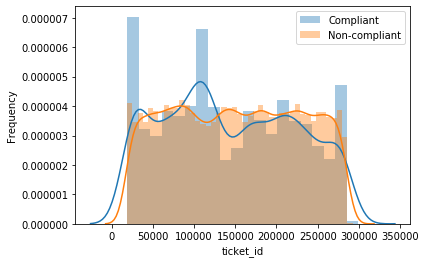

In [100]:
f, ax = plt.subplots(1, 1)
sns.distplot(X_train_finitey['ticket_id'].loc[[i for i in y_train_finitey.index if y_train_finitey[i] == 1]],label='Compliant')
sns.distplot(X_train_finitey['ticket_id'].loc[[i for i in y_train_finitey.index if y_train_finitey[i] == 0]],label='Non-compliant')
ax.legend()
plt.ylabel('Frequency')
plt.show()

No obvious differences aside from the rough distribution for compliant tickets, likely owing to the reduced number.

Next we'll look at how uniform the rate of compliance is across agencies and inspectors.

In [101]:
def calc_feature_compliancerate(Xdf,ydf,feature,sortval='mean'):
    feature_compliance = (Xdf.join(ydf))[[feature,'compliance']]
    groupedfeature = feature_compliance.groupby([feature]).mean()
    return groupedfeature.join(feature_compliance.groupby([feature]).count(),lsuffix='_mean',rsuffix='_count').sort_values(by='compliance_'+sortval,ascending=False)
calc_feature_compliancerate(X_train_finitey,y_train_finitey,'agency_name')

,compliance_mean,compliance_count
agency_name,,
Detroit Police Department,0.121897,2256
Department of Public Works,0.091391,26239
Health Department,0.063716,3547
"Buildings, Safety Engineering & Env Department",0.062135,47928
Neighborhood City Halls,0.000000,1


In [102]:
X_train_finitey['inspector_name_lower'] = X_train_finitey['inspector_name'].str.lower()
inspector_compliancerate = calc_feature_compliancerate(X_train_finitey,y_train_finitey,'inspector_name_lower')
inspector_compliancerate.loc[inspector_compliancerate['compliance_count'] > 1000]

,compliance_mean,compliance_count
inspector_name_lower,,
"legge, gerald",0.101550,1290
"havard, jacqueline",0.100332,1206
"johnson, lois",0.100099,1009
"jones, leah",0.095989,1521
"danielson, keith d",0.089331,1959
"davis, darlene",0.086552,1398
"zizi, josue",0.080000,2550
"sharpe, anthony",0.078859,1192
"samaan, neil j",0.076994,4364


# First features of (some) value found

The Detroit Police Department issues tickets with a significantly higher likelihood of non-compliance relative to the other agencies. In addition, despite issuing nearly 10,000 tickets John Morris has a non-compliance rate significantly below the average of 7.2% (while still accounting for the 48 inspectors being looked at). We will want to include this in our model but must be careful not to overfit as a result of the low number of some ticket issued by particular departments and inspectors.

In [103]:
X_train_finitey['violator_name_lower'] = X_train_finitey['violator_name'].str.lower()
X_train_finitey['violator_name_lower'][X_train_finitey['violator_name_lower'].isnull()] = [x for x,i in enumerate(X_train_finitey['violator_name_lower'].isnull()) if i == True]
violator_compliancerate = calc_feature_compliancerate(X_train_finitey,y_train_finitey,'violator_name_lower',sortval='count')
violator_compliancerate.loc[violator_compliancerate['compliance_count'] >= 40]

,compliance_mean,compliance_count
violator_name_lower,,
"investment, acorn",0.000000,346
"investment co., acorn",0.000000,182
"bank, wells fargo",0.006993,143
"miller, john",0.011364,88
"stehlik, jerry",0.159091,88
"new york, bank of",0.026316,76
"snow, george",0.000000,71
"national trust co., deutsche bank",0.032787,61
"ldha, barclay",0.000000,57


A common name in the violator column has some form of "Acorn" in it and has no compliance (when the exact name is ticketed > 50 times). See if this is a common occurance. In addition, bank owned properties may have less oversight than personally owned ones and this may affect compliance.

In [104]:
def calc_featurecontains_compliancerate(feature,containphrase):
    feature_compliance = (X_train_finitey.join(y_train_finitey))[[feature,'compliance']].dropna()
    res = ((feature_compliance['compliance'][feature_compliance[feature].str.contains(containphrase, flags = re.IGNORECASE,na=False)]).mean(),feature_compliance['compliance'][feature_compliance[feature].str.contains(containphrase, flags = re.IGNORECASE,na=False)].count())
    print('Average compliance = %s, total at fault tickets = %s for "' % res + containphrase + '"')
calc_featurecontains_compliancerate('violator_name_lower','acorn')
calc_featurecontains_compliancerate('violator_name_lower','bank')
calc_featurecontains_compliancerate('violator_name_lower','federal')
calc_featurecontains_compliancerate('violator_name_lower','mortgage')

Average compliance = 0.0, total at fault tickets = 802 for "acorn"
Average compliance = 0.04262000897263347, total at fault tickets = 2229 for "bank"
Average compliance = 0.18446601941747573, total at fault tickets = 309 for "federal"
Average compliance = 0.08699719363891488, total at fault tickets = 1069 for "mortgage"


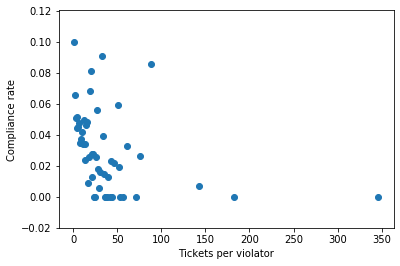

In [105]:
plt.scatter(violator_compliancerate.groupby(['compliance_count']).mean().index,violator_compliancerate.groupby(['compliance_count']).mean()['compliance_mean'])
plt.xlabel('Tickets per violator')
plt.ylabel('Compliance rate')
plt.show()

Aside from Jerry Stehlik, there's a fairly clear trend of repeat violators having a lower chance of compliance. We'll want to create the number of ticketed (and liable) offenses as a feature.

Finally, let's look at the city (in particular whether the violator being located within Detroit affects compliance), disposition, and violation code to see if there's any information in those features.

In [106]:
X_train_finitey['city_lower'] = X_train_finitey['city'].str.lower()
city_compliancerate = calc_feature_compliancerate(X_train_finitey,y_train_finitey,'city_lower',sortval='count')
city_compliancerate.loc[city_compliancerate['compliance_count'] >= 100].sort_values(by='compliance_mean')

,compliance_mean,compliance_count
city_lower,,
fort mill,0.000000,145
plano,0.007407,135
gilbert,0.012346,243
san jose,0.019048,105
irvine,0.020513,195
irving,0.025862,116
highland park,0.025974,154
jacksonville,0.026316,152
fort worth,0.026846,149


In [107]:
calc_featurecontains_compliancerate('city_lower','detroit')

Average compliance = 0.07142857142857142, total at fault tickets = 48048 for "detroit"


In [108]:
calc_feature_compliancerate(X_train_finitey,y_train_finitey,'disposition',sortval='count')

,compliance_mean,compliance_count
disposition,,
Responsible by Default,0.038448,69237
Responsible by Admission,0.288185,6822
Responsible by Determination,0.301600,3813
Responsible (Fine Waived) by Deter,1.000000,99


In [109]:
violation_compliancerate = calc_feature_compliancerate(X_train_finitey,y_train_finitey,'violation_code',sortval='mean')
violation_compliancerate.loc[violation_compliancerate['compliance_count'] >= 40]

,compliance_mean,compliance_count
violation_code,,
9-1-111,0.226667,75
22-2-61,0.221311,366
61-81.0100/32.0066,0.155556,225
9-1-107,0.154930,71
22-2-22(a),0.150000,40
9-1-103(C),0.147718,1293
9-1-209,0.144444,90
22-2-43,0.140334,1019
61-5-21,0.131313,99


It appears Detroit violators have roughly the same compliance rate as the overall average and while the city and violation code may have information, they are likely correlated with the violator name and judgment amount. However, disposition seems to have a significant impact.

# Constructing new features
We will create new features based on the following: total violations cited per violator, the presence of common and significant words in names such as acorn, bank, and federal, and the disposition.

In [110]:
X_train_finitey['total_violation_counts']=np.nan
X_train_finitey['total_violation_counts']=[violator_compliancerate['compliance_count'][violator_compliancerate.index == n].values[0] for i,n in enumerate(X_train_finitey['violator_name_lower'])]

In [111]:
def addcontainscolumn(df,containword):
    df['contains_'+containword]=0
    df['contains_'+containword][df['violator_name_lower'].str.contains(containword, flags = re.IGNORECASE,na=False)] = 1
addcontainscolumn(X_train_finitey,'acorn')
addcontainscolumn(X_train_finitey,'bank')
addcontainscolumn(X_train_finitey,'federal')

In [112]:
X_test_finitey = X_test.loc[np.isfinite(y_test)]
y_test_finitey = y_test[np.isfinite(y_test)]

maxtrainval=X_train_finitey.shape[0]
X_test_finitey['violator_name_lower'] = X_test_finitey['violator_name'].str.lower()
X_test_finitey['violator_name_lower'][X_test_finitey['violator_name_lower'].isnull()] = [x+maxtrainval for x,i in enumerate(X_test_finitey['violator_name_lower'].isnull()) if i == True]
test_violator_counts=X_test_finitey[['violator_name_lower','late_fee']].groupby('violator_name_lower').count()
test_violator_counts=test_violator_counts.rename(columns={'late_fee':'compliance_count'})

In [113]:
X_test_finitey['total_violation_counts']=np.nan
X_test_finitey['total_violation_counts'] = [test_violator_counts['compliance_count'][test_violator_counts.index == n].values[0] for i,n in enumerate(X_test_finitey['violator_name_lower'])]

addcontainscolumn(X_test_finitey,'acorn')
addcontainscolumn(X_test_finitey,'bank')
addcontainscolumn(X_test_finitey,'federal')

In [114]:
features=['late_fee','discount_amount','judgment_amount','disposition','contains_acorn','contains_bank','contains_federal','total_violation_counts']
dummy_X_train=pd.get_dummies(X_train_finitey[features])
dummy_X_test = pd.get_dummies(X_test_finitey[features])

# Performing grid search cross-validation to determine best parameters

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(random_state=19)

param_grid = {
    'n_estimators': [5,10,15,20,25],
    'max_depth': [5,10,15,20,25,30,35],
    'min_samples_leaf': [20,30,40,50,60]
}
search_rfc = GridSearchCV(rfc, param_grid,cv=3,scoring='roc_auc')
search_rfc.fit(dummy_X_train, y_train_finitey)

print('rfc AUC for ROC curve:',search_rfc.best_score_)
print('best parameters:',search_rfc.best_params_)


rfc AUC for ROC curve: 0.8131631400494769
best parameters: {'max_depth': 15, 'min_samples_leaf': 20, 'n_estimators': 20}


# Results of fitting

We will look at a ranking of the feature importances as well as the AUC for the ROC curve on the test set.

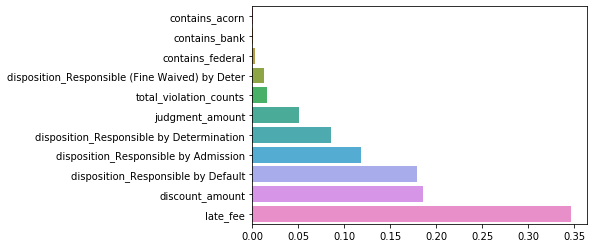

In [116]:
rfc=RandomForestClassifier(max_depth=15,min_samples_leaf=20,n_estimators=15,random_state=19).fit(dummy_X_train, y_train_finitey)
sortind=np.argsort(rfc.feature_importances_)
feature_list=[]
importance_list=[]
for features, coefficients in zip(dummy_X_train.columns[sortind], rfc.feature_importances_[sortind]):
    feature_list.append(features)
    importance_list.append(coefficients)
    
sns.barplot(importance_list,feature_list)
plt.show()

Test AUC for ROC curve:  0.8080601029670298


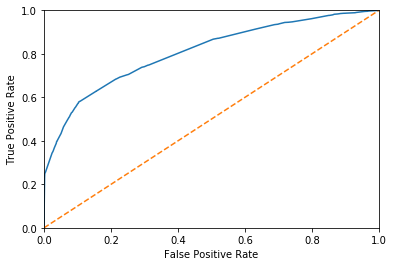

               precision    recall  f1-score   support

Non-compliant       0.95      1.00      0.97     74189
    Compliant       0.90      0.25      0.39      5720

     accuracy                           0.94     79909
    macro avg       0.92      0.62      0.68     79909
 weighted avg       0.94      0.94      0.93     79909



In [117]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

y_score = rfc.predict_proba(dummy_X_test)
print('Test AUC for ROC curve: ',roc_auc_score(y_test_finitey,y_score[:,1]))
fpr, tpr, thresholds = roc_curve(y_test_finitey, y_score[:,1])
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print(classification_report(y_test_finitey, rfc.predict(dummy_X_test),target_names=['Non-compliant','Compliant']))

In the end, it's not terribly surprising that the late fee is the most predictive feature for ticket compliance. With a 0.81 AUC, this model appears to give us reasonably good ranking of which violations to prioritize in a plan to promote compliance. In particular, it appears that the ~20% most likely non-compliant tickets could be targeted without significantly impacting any likely compliant tickets.